# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [ ]:
import sys
import gym
from collections import deque
import random
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt

import check_test
from plot_utils import plot_values

%matplotlib inline

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

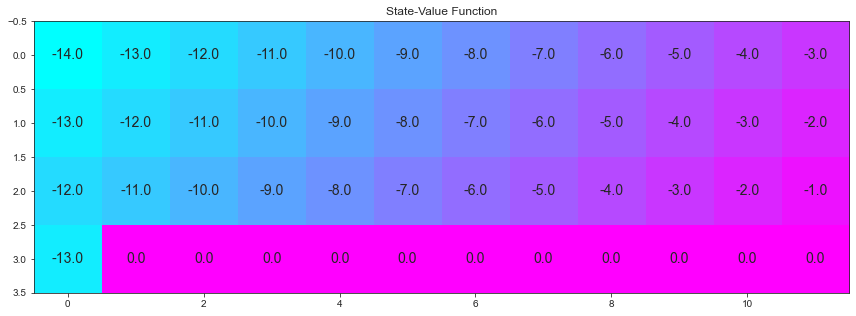

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [62]:
def epsilon_greedy(Q, state, epsilon, n_actions):        
    # choose action according to epsilon-greedy policy
    if random.random() > epsilon:
        return np.argmax(Q[state])
    else:
#         return env.action_space.sample()
        return random.choice(np.arange(env.action_space.n))
    
    
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    
    # get value of state, action pair at next time step
    if next_state is not None:
        Qsa_next = Q[next_state][next_action]
    else:
        Qsa_next = 0
        
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    
    return new_value

In [63]:
def sarsa(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.9999, eps_min=0.001, plot_every=100):
    n_actions = env.action_space.n
    epsilon = eps_start
    Q = defaultdict(lambda: np.zeros(n_actions))
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(num_episodes):
        # monitor progress
        if i_episode % plot_every == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}, average score: {np.mean(tmp_scores) if len(tmp_scores) > 0 else 0}, epsilon: {epsilon}", end="")
            sys.stdout.flush()
    
        score = 0
        state = env.reset()
    
        epsilon = 1.0 / (i_episode + 1)
        action = epsilon_greedy(Q, state, epsilon, n_actions)
        
        while True:
            next_state, reward, done, _ = env.step(action)
            score += reward
            
            if not done:
                next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state, next_action)

                state = next_state
                action = next_action

            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward)
                tmp_scores.append(score)    # append score
                break
                
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))  
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 49900/50000, average score: -13.0, epsilon: 2.004008016032064e-0555

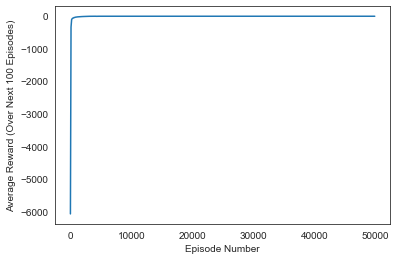

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  3  1  2  0  1  0  1  1  0  1  2]
 [ 0  1  1  3  1  0  0  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


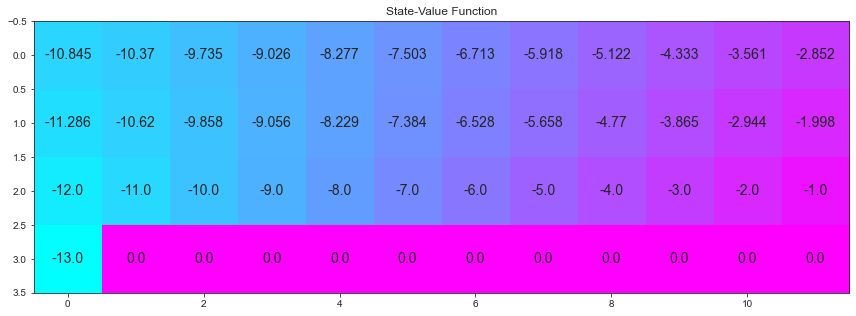

In [64]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 50000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [106]:
def greedy(Q, state):        
    # choose action according to greedy policy
    return np.max(Q[state])
    

def epsilon_greedy(Q, state, epsilon, n_actions):        
    # choose action according to epsilon-greedy policy
    if random.random() > epsilon:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(n_actions))

In [107]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    
    # get value of state, action pair at next time step
    if next_state is not None:
        Qsa_next = greedy(Q, next_state)
    else:
        Qsa_next = 0
        
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + alpha * (target - current) # get updated value
    
    return new_value

In [108]:
def q_learning(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, plot_every=100):
    n_actions = env.action_space.n
    
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(n_actions))
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
        
    # loop over episodes
    for i_episode in range(num_episodes):
            
        score = 0
        state = env.reset()
    
        epsilon = 1.0 / (i_episode + 1)
        action = epsilon_greedy(Q, state, epsilon, n_actions)
        
        # monitor progress
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}, average score: {np.mean(tmp_scores) if len(tmp_scores) > 0 else 0}, epsilon: {epsilon}", end="")
            sys.stdout.flush()
        
        while True:
            next_state, reward, done, _ = env.step(action)
            score += reward
            
            if not done:
                next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)
                Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state)

                state = next_state
                action = next_action

            if done:
                Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, state, action, reward)
                tmp_scores.append(score)    # append score
                break
                
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))  
            
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 4900/5000, average score: -13.0, epsilon: 0.000204039991838400333

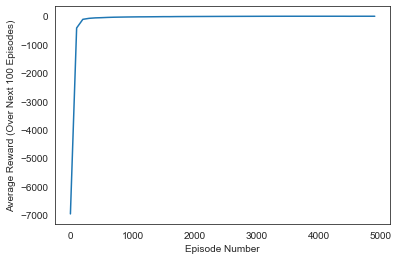

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  3  2]
 [ 1  0  2  0  2  1  2  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


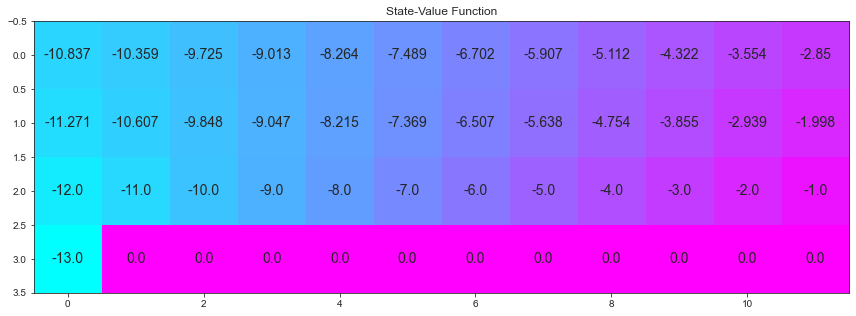

In [109]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

def epsilon_greedy(Q, state, epsilon, n_actions):        
    # choose action according to epsilon-greedy policy
    if random.random() > epsilon:
        return np.argmax(Q[state])
    else:
#         return env.action_space.sample()
        return random.choice(np.arange(env.action_space.n))
    
    
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    
    # get value of state, action pair at next time step
    if next_state is not None:
        Qsa_next = Q[next_state][next_action]
    else:
        Qsa_next = 0
        
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    
    return new_value### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [123]:
def epsilon_greedy(Q, state, epsilon, n_actions):        
    # choose action according to epsilon-greedy policy
    if random.random() > epsilon:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(n_actions))
    
    
def update_Q_expectedsarsa(alpha, gamma, Q, state, action, reward, n_actions, epsilon, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    
    policy_s = np.ones(n_actions) * epsilon / n_actions  # current policy (for next state S')
    policy_s[np.argmax(Q[next_state])] = 1 - epsilon + (epsilon / n_actions) # greedy action
    Qsa_next = np.dot(Q[next_state], policy_s)         # get value of state at next time step
        
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + alpha * (target - current) # get updated value
    
    return new_value

In [144]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    n_actions = env.action_space.n
    
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(n_actions))
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
        
    # loop over episodes
    for i_episode in range(num_episodes):
            
        score = 0
        state = env.reset()
    
        epsilon = 0.1 / (i_episode + 1)
        action = epsilon_greedy(Q, state, epsilon, n_actions)
        
        # monitor progress
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}, average score: {np.mean(tmp_scores) if len(tmp_scores) > 0 else 0}, epsilon: {epsilon}", end="")
            sys.stdout.flush()
        
        while True:
            next_state, reward, done, _ = env.step(action)
            score += reward
            
            if not done:
                next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)
                Q[state][action] = update_Q_expectedsarsa(alpha, gamma, Q, state, action, reward, n_actions, epsilon, next_state)

                state = next_state
                action = next_action

            if done:
                Q[state][action] = update_Q_expectedsarsa(alpha, gamma, Q, state, action, reward, n_actions, epsilon)
                tmp_scores.append(score)    # append score
                break
                
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))  
            
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 400/500, average score: -13.02, epsilon: 0.0002493765586034913

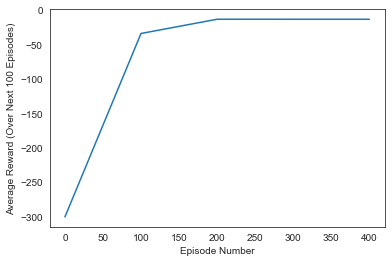

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  2  1  1  1  1  2  1  1  2]
 [ 1  1  2  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


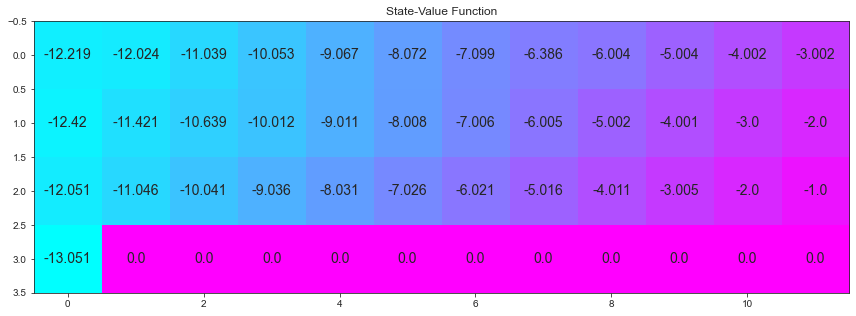

In [145]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 500, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])